# Logistic Regression 

## Data Exploration/Inspection

In [88]:
import pandas as pd

df = pd.read_csv('data/COVID-19_Case_Surveillance_Public_Use_Data_with_Geography_20241111.csv')

In [89]:
df.head(5)

,case_month,res_state,state_fips_code,res_county,county_fips_code,age_group,sex,race,ethnicity,case_positive_specimen_interval,case_onset_interval,process,exposure_yn,current_status,symptom_status,hosp_yn,icu_yn,death_yn,underlying_conditions_yn
0,2024-06,VA,51,VIRGINIA BEACH CITY,51810.0,65+ years,Female,White,Non-Hispanic/Latino,0.0,0.0,Routine surveillance,Yes,Laboratory-confirmed case,Symptomatic,No,No,No,Yes
1,2024-06,VA,51,VIRGINIA BEACH CITY,51810.0,65+ years,Female,White,Non-Hispanic/Latino,1.0,0.0,Routine surveillance,Yes,Probable Case,Symptomatic,No,No,No,Yes
2,2024-06,VA,51,VIRGINIA BEACH CITY,51810.0,65+ years,Female,White,Non-Hispanic/Latino,0.0,0.0,Routine surveillance,Yes,Probable Case,Symptomatic,Yes,No,No,Yes
3,2024-06,VA,51,VIRGINIA BEACH CITY,51810.0,65+ years,Female,White,Non-Hispanic/Latino,0.0,0.0,Routine surveillance,Yes,Probable Case,Symptomatic,No,No,No,Yes
4,2024-06,VA,51,VIRGINIA BEACH CITY,51810.0,65+ years,Female,White,Non-Hispanic/Latino,0.0,0.0,Routine surveillance,Yes,Probable Case,Symptomatic,No,No,No,Yes


In [90]:
df = df.drop(['res_state', 'res_county'], axis=1)

In [91]:
categorical_cols = ['case_month','state_fips_code', 'county_fips_code', 'age_group',
                  'sex', 'race', 'ethnicity', 'process', 'exposure_yn', 'current_status', 
                  'symptom_status', 'hosp_yn', 'icu_yn', 'underlying_conditions_yn']
numerical_cols = ['case_positive_specimen_interval', 'case_onset_interval']

In [92]:
import textwrap

In [93]:
def print_na_count(df, col):
    na_count = df[df[col].isna()].shape[0]
    print(f'{col} null values: {na_count}')


In [94]:
def print_unique(df, col):
    u = df[col].unique()
    print(u.shape)
    if u.shape[0] <= 10:
        print(u)
    else:
        print(textwrap.shorten(str(u), width=70, placeholder="..."))

In [95]:
for col in categorical_cols:
    print(col)
    print_unique(df, col)
    print_na_count(df, col)


case_month
(52,)
['2024-06' '2024-05' '2024-04' '2024-03' '2024-02' '2024-01'...
case_month null values: 0
state_fips_code
(30,)
[51 39 23 16 55 21 11 41 31 20 32 28 78 12 50 36 2 18 49 42 19 72...
state_fips_code null values: 0
county_fips_code
(464,)
[51810. nan 51177. 39049. 23019. 23031. 51087. 51710. 23005. 39139....
county_fips_code null values: 11756
age_group
(4,)
['65+ years' '18 to 49 years' '50 to 64 years' '0 - 17 years']
age_group null values: 0
sex
(2,)
['Female' 'Male']
sex null values: 0
race
(6,)
['White' 'Black' 'Multiple/Other' 'Asian' 'American Indian/Alaska Native'
 'Native Hawaiian/Other Pacific Islander']
race null values: 0
ethnicity
(2,)
['Non-Hispanic/Latino' 'Hispanic/Latino']
ethnicity null values: 0
process
(9,)
['Routine surveillance' 'Laboratory reported' 'Provider reported'
 'Clinical evaluation' 'Multiple' 'Other'
 'Contact tracing of case patient' 'Routine physical examination'
 'Autopsy']
process null values: 0
exposure_yn
(1,)
['Yes']
exposure_yn nul

In [96]:
for col in numerical_cols:
    print(col)
    print_na_count(df, col)

case_positive_specimen_interval
case_positive_specimen_interval null values: 109308
case_onset_interval
case_onset_interval null values: 13813


County fips code seems to be the only categorical column with nulls.\
I may possibly remove case_positive_specimen_interval, case_onset_interval...\
These are calculated weeks difference from pos_spec_dt and onset_dt respectively...\
maybe making them zero if null makes sense since the record wouldnt exist without knowing they have covid...

In [97]:
categorical_cols = [x for x in categorical_cols if x != 'county_fips_code']
df = df.drop(['county_fips_code'], axis=1)
categorical_cols

['case_month',
 'state_fips_code',
 'age_group',
 'sex',
 'race',
 'ethnicity',
 'process',
 'exposure_yn',
 'current_status',
 'symptom_status',
 'hosp_yn',
 'icu_yn',
 'underlying_conditions_yn']

In [98]:
df[numerical_cols] = df[numerical_cols].fillna(0)

## One Hot Encoding

In [99]:
import numpy as np
import sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [100]:
np.random.seed(777)

In [101]:
print(sklearn.__version__)

1.6.0


In [102]:
encoder = OneHotEncoder(sparse_output=False, drop='if_binary')
ct = ColumnTransformer(
    transformers=[
        ('onehot', encoder, categorical_cols)
    ],
    remainder='passthrough'  # Keep other columns as is
)
transformed_array = ct.fit_transform(df)
print(transformed_array.shape)

(175407, 112)


categorical columns are now 533 one hot columns

In [103]:
onehot_features = ct.named_transformers_['onehot'].get_feature_names_out(categorical_cols)
numeric_features = df.columns.difference(categorical_cols)
all_features = np.concatenate([onehot_features, numeric_features])

print(f'onehot {onehot_features.shape} + numeric {numeric_features.shape} = all {all_features.shape}')
print('random one hot features:')
print(onehot_features[np.random.randint(0, onehot_features.shape[0], size=(10))])

onehot (109,) + numeric (3,) = all (112,)
random one hot features:
['exposure_yn_Yes' 'case_month_2024-02' 'state_fips_code_19'
 'case_month_2023-05' 'race_American Indian/Alaska Native'
 'case_month_2024-04' 'state_fips_code_41' 'case_month_2022-08'
 'case_month_2023-06' 'race_Black']


In [104]:
transformed_df = pd.DataFrame(
    transformed_array,
    columns=all_features
)

## Model Training

In [105]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

### Define features, target, and train/test split

In [106]:
X = transformed_df[transformed_df.columns.difference(['death_yn'])] 
y = transformed_df['death_yn'].map({'Yes': 1, 'No': 0})
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [107]:
from sklearn.model_selection import train_test_split, StratifiedKFold
import matplotlib.pyplot as plt

In [108]:
# Set up cross-validation
n_splits = 5
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize arrays for ROC curve analysis
cv_scores = []
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

# Create figure for ROC curves
plt.figure(figsize=(10, 8))

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

In [109]:
from sklearn.metrics import roc_curve, auc, accuracy_score, classification_report, confusion_matrix


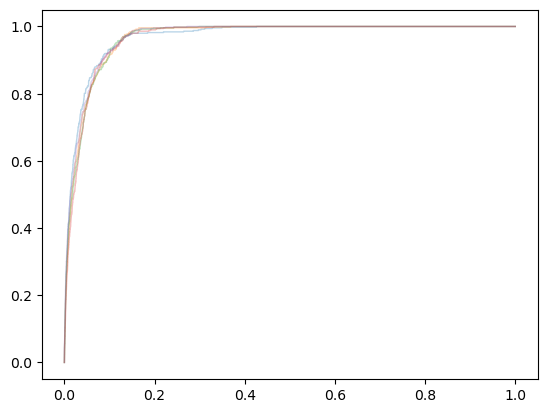

In [110]:
# Perform cross-validation and plot ROC curves
for fold, (train_idx, val_idx) in enumerate(cv.split(X_train, y_train)):
    X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    # Train model
    model = LogisticRegression(max_iter=1000)
    model.fit(X_fold_train, y_fold_train)
    
    # Get predictions
    y_fold_pred = model.predict(X_fold_val)
    fold_score = accuracy_score(y_fold_val, y_fold_pred)
    cv_scores.append(fold_score)
    
    # Compute ROC curve and plot
    y_fold_proba = model.predict_proba(X_fold_val)[:, 1]
    fpr, tpr, _ = roc_curve(y_fold_val, y_fold_proba)
    
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label=f'ROC fold {fold+1} (AUC = {auc(fpr, tpr):.2f})')
    
    # Store interpolated TPR values
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(auc(fpr, tpr))

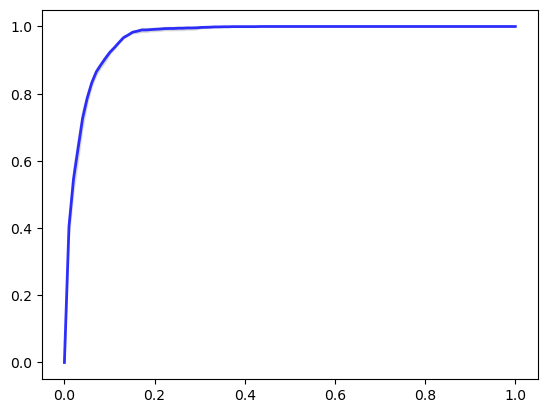

In [111]:
# Plot mean ROC curve and confidence interval
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = np.mean(aucs)
std_auc = np.std(aucs)

plt.plot(mean_fpr, mean_tpr, 'b-',
         label=f'Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})',
         lw=2, alpha=0.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.2,
                 label=f'± 1 std. dev.')

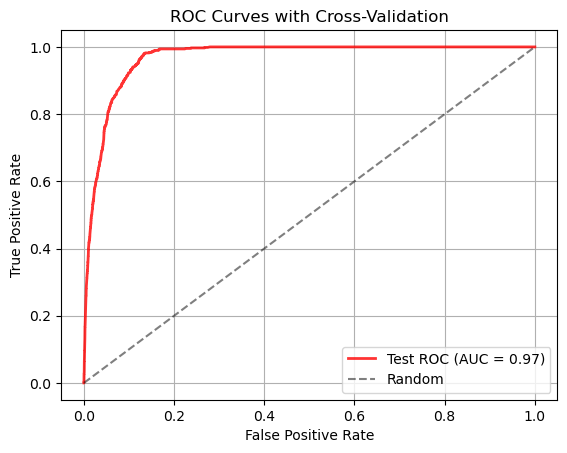

In [112]:
# Add final test set ROC curve
final_model = LogisticRegression(max_iter=1000)
final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)
y_pred_proba = final_model.predict_proba(X_test)[:, 1]

fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr_test, tpr_test, 'r-',
         label=f'Test ROC (AUC = {auc(fpr_test, tpr_test):.2f})',
         lw=2, alpha=0.8)

# Add random prediction line
plt.plot([0, 1], [0, 1], 'k--', label='Random', alpha=0.5)

# Customize plot
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves with Cross-Validation')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [113]:
# Print cross-validation results
print("\nCross-validation Results:")
for fold, score in enumerate(cv_scores, 1):
    print(f"Fold {fold}: {score:.4f}")
print(f"\nMean CV Score: {np.mean(cv_scores):.4f} (±{np.std(cv_scores):.4f})")

# Print final model results
print("\nFinal Model Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Cross-validation Results:
Fold 1: 0.9831
Fold 2: 0.9829
Fold 3: 0.9830
Fold 4: 0.9820
Fold 5: 0.9831

Mean CV Score: 0.9828 (±0.0004)

Final Model Results:
Accuracy: 0.9816

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     34409
           1       0.57      0.17      0.26       673

    accuracy                           0.98     35082
   macro avg       0.78      0.58      0.63     35082
weighted avg       0.98      0.98      0.98     35082



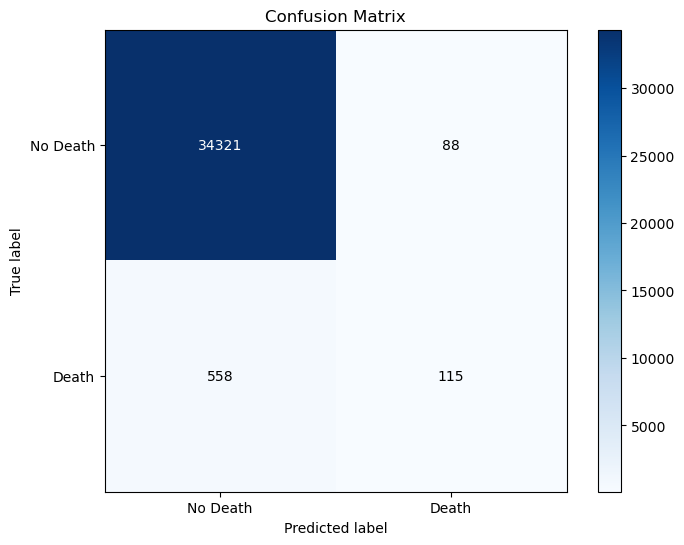

In [114]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
conf_matrix = confusion_matrix(y_test, y_pred)
plt.imshow(conf_matrix, cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()

# Add labels to each cell
thresh = conf_matrix.max() / 2
for i in range(2):
    for j in range(2):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                ha="center", va="center",
                color="white" if conf_matrix[i, j] > thresh else "black")

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.xticks([0, 1], ['No Death', 'Death'])
plt.yticks([0, 1], ['No Death', 'Death'])
plt.show()

In [115]:
# Save ROC data
# Create directories if they don't exist
os.makedirs('data/logisitic_regression', exist_ok=True)

# Prepare ROC data for saving
roc_data = {
    'mean_fpr': mean_fpr.tolist(),
    'mean_tpr': mean_tpr.tolist(),
    'mean_auc': float(mean_auc),
    'std_auc': float(std_auc),
    'final_fpr': fpr_test.tolist(),
    'final_tpr': tpr_test.tolist(),
    'final_auc': float(auc(fpr_test, tpr_test))
}

# Save to JSON
with open('data/logisitic_regression/roc_data.json', 'w') as f:
    json.dump(roc_data, f)

In [116]:
# Print class distribution information
lives = y_train[y_train == 0].shape[0]
dies = y_train[y_train == 1].shape[0]
print(f"Training set - live count: {lives}, death count: {dies}")
print(f"Ratio (lives/deaths): {lives/dies:.2f}")

lives = df[df['death_yn'] == 'No'].shape[0]
dies = df[df['death_yn'] == 'Yes'].shape[0]
print(f"\nFull dataset - live count: {lives}, death count: {dies}")
print(f"Ratio (lives/deaths): {lives/dies:.2f}")

Training set - live count: 137833, death count: 2492
Ratio (lives/deaths): 55.31

Full dataset - live count: 172242, death count: 3165
Ratio (lives/deaths): 54.42
